In [1]:
import sys
import os

# Get the parent directory
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

# Add parent directory to sys.path
sys.path.append(parent_dir)

print(parent_dir)

/home/adam/dev/gradual-aacbr/examples


In [2]:
import numpy as np
from matplotlib import pyplot as plt
import torch
import torch.optim as optim

import deeparguing.aacbr as aacbr


from helper import load_mushroom, split_data, normalise_input
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import deeparguing.feature_extractor.mlp_extractor as mlpe

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
SEED = 1

### DATA SET

In [5]:
X, y = load_mushroom()

X = X.astype(np.float32)
np.random.seed(SEED)
indices = np.random.permutation(len(X))

X = X[indices]
y = y[indices]

y = np.argmax(y, axis=-1)

print(X.shape)

all_y = np.unique(y, axis=0)
print(all_y)

(8124, 117)
[0 1]


In [6]:
# full_train_size = 625
full_train_size = 250
train_size = int(full_train_size * 0.8)

# train_full, train, val, test = split_data(X, y, SEED)

# print(f"Test Size:  {len(test['X'])}")
# print(f"Train Size:  {len(train['X'])}")
# print(f"Validation Size:  {len(val['X'])}")

train_full = {"X": X[:full_train_size], "y": y[:full_train_size]}
train = {"X": X[:train_size], "y": y[:train_size]}
val = {"X": X[train_size:full_train_size], "y": y[train_size:full_train_size]}
test = {"X": X[full_train_size:], "y": y[full_train_size:]}

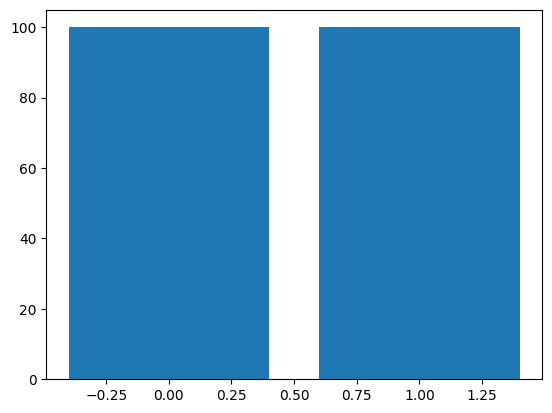

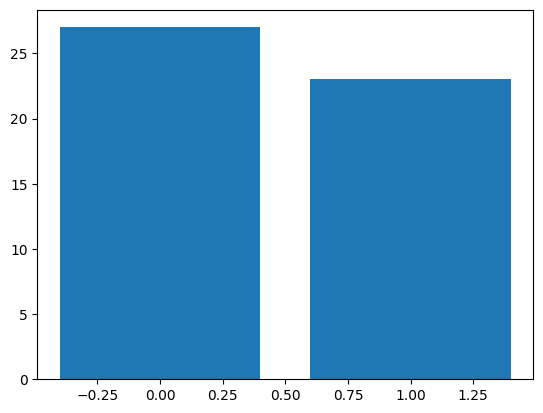

In [7]:
result = np.unique(train['y'], axis=0, return_counts=True)
plt.bar(x = result[0] , height = result[1])
plt.show()

result = np.unique(val['y'], axis=0, return_counts=True)
plt.bar(x = result[0] , height = result[1])
plt.show()

In [8]:
# X_train, y_train           = train["X"]     , train["y"]      
# X_val, y_val               = val["X"]       , val["y"]        
# X_test, y_test             = test["X"]      , test["y"]       

In [9]:
X_train, y_train           = torch.tensor(train["X"]     , device=device),      torch.tensor(train["y"],      dtype=torch.float32, device=device)
X_val, y_val               = torch.tensor(val["X"]       , device=device),      torch.tensor(val["y"],        dtype=torch.float32, device=device)
X_test, y_test             = torch.tensor(test["X"]      , device=device),      torch.tensor(test["y"],       dtype=torch.float32, device=device)

## Autoencoder

In [10]:
EPOCHS = 2000
LR = 1e-3
torch_seed = 0
torch.manual_seed(torch_seed) 

In [11]:
no_features = X_train.shape[-1]

HIDDEN_SIZE = 30
model = mlpe.MLPExtractor(no_features, [HIDDEN_SIZE], no_features, output_activation=torch.nn.Sigmoid()).to(device)

criterion = torch.nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr=LR)

In [12]:
losses = np.zeros((EPOCHS))
for epoch in range(EPOCHS):

    optimizer.zero_grad()
    reconstruction = model(X_train)
    loss = criterion(reconstruction, X_train)
    loss.backward()
    losses[epoch] = loss.item()
    optimizer.step()

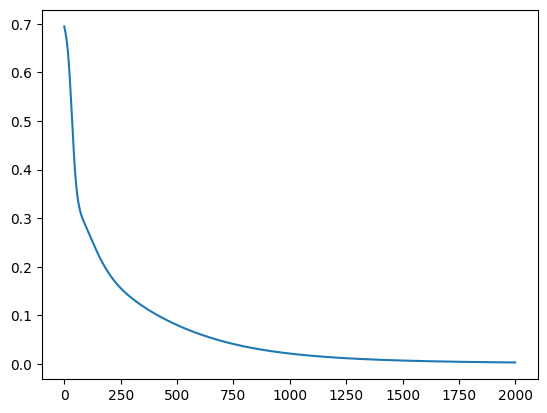

In [13]:
plt.plot(losses)
plt.show()

In [14]:
k = 22
for name, param in model.named_parameters():
    if name == "layers.0.weight":
        # print(name)
        # print(param.data.shape)
        avg = torch.mean(param.data, dim=0)
        # print(avg)
        values, indices = torch.topk(avg, k, largest=True, sorted=True)
        # print(values)
        # print(indices)
        
        break
indices = indices.cpu().numpy()
print(f"Top {k} features are", indices)


Top 22 features are [ 88  32  82  85  35  33  50   2  15   0  90  80  98  39  52   8 114 111
  20 107  63  64]


In [15]:
X_train, y_train = X_train.cpu().numpy(), y_train.cpu().numpy()
X_val, y_val     =   X_val.cpu().numpy(),   y_val.cpu().numpy()    
X_test, y_test   =  X_test.cpu().numpy(),  y_test.cpu().numpy()  

In [16]:
X_train = X_train[:, indices]
X_val = X_val[:, indices]
X_test = X_test[:, indices]

### TRAIN MODEL

In [17]:
DEFAULT_CASE = np.zeros(X_train.shape[1])

In [18]:
def eval_model(model, X, y):
    # Assess the model pre-training
        y_preds = model(X)
        y_actual = y

        # print("predictions", y_preds)
        # print("actuals", y_actual)

        results = ( 
            accuracy_score(y_actual, y_preds),
            precision_score(y_actual, y_preds, average='macro', zero_division=0),
            recall_score(y_actual, y_preds, average='macro', zero_division=0),
            f1_score(y_actual, y_preds, average='macro', zero_division=0),
            confusion_matrix(y_actual, y_preds)
        )


        print("Accuracy, precision, recall, f1")
        print(results[:-1])
        print("confusion matrix:")
        print(results[-1])

In [19]:
def strict_subset(a, t):
    if a.ndim == 1:
        a = a[np.newaxis, :]
    if t.ndim == 1:
        t = t[np.newaxis, :]
    result = np.logical_and(np.all(a >= t, axis = -1), np.any(a != t, axis = -1))
    return result

In [20]:

model = aacbr.AACBR(X_train, y_train, strict_subset, DEFAULT_CASE, all_y[1:2], 
                    use_symmetric_attacks=False, build_parallel=False)

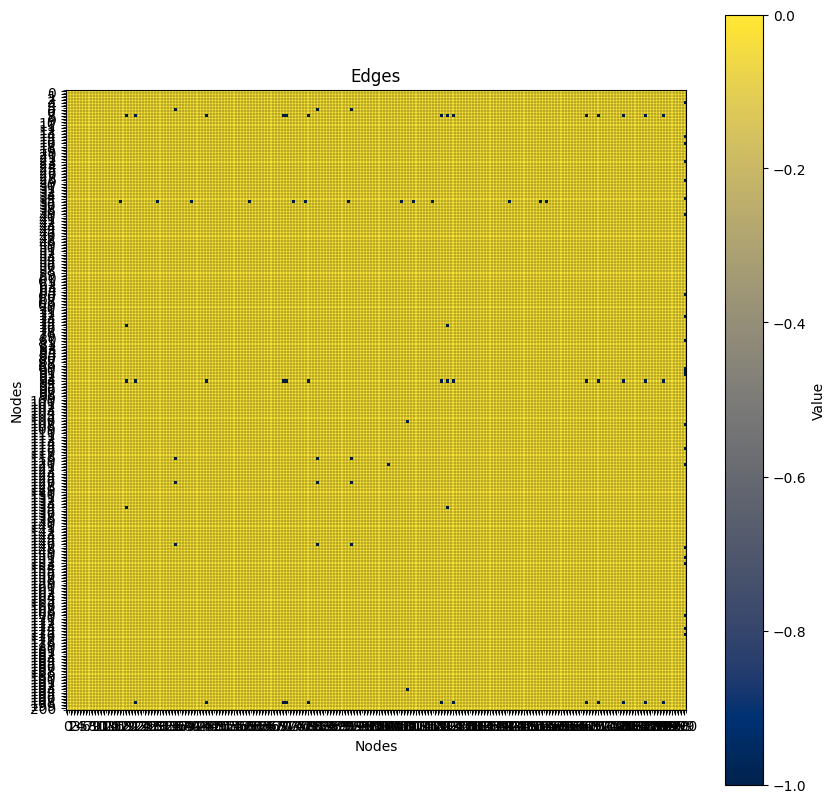

In [21]:
model.show_matrix()

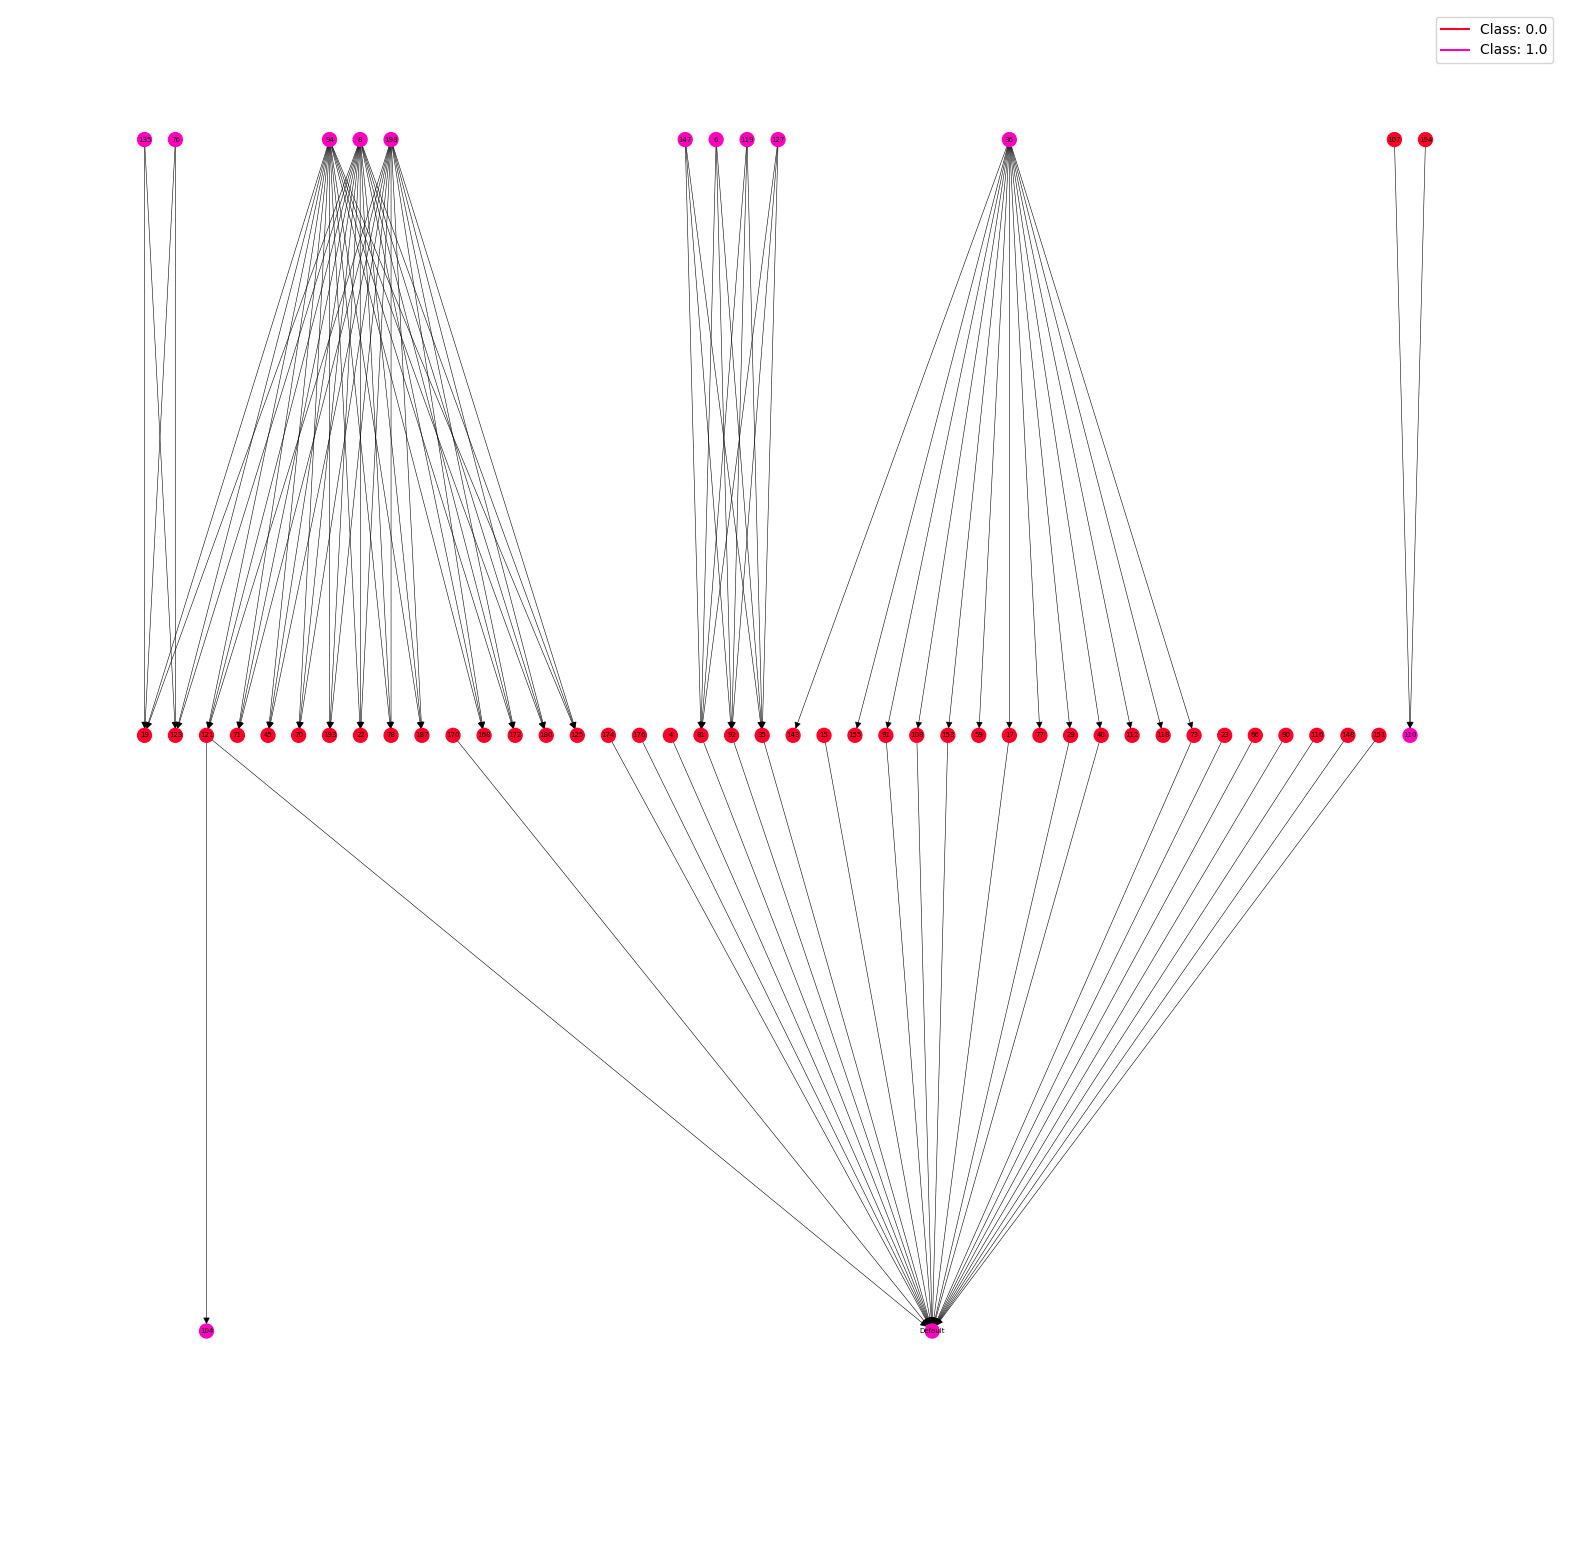

In [22]:
model.show_graph_with_labels()

In [23]:
eval_model(model, X_val, y_val)

Accuracy, precision, recall, f1
(0.88, np.float64(0.88), np.float64(0.8824476650563606), np.float64(0.8798076923076923))
confusion matrix:
[[23  4]
 [ 2 21]]


In [24]:
assert(False)

AssertionError: 

In [25]:
eval_model(model, X_test, y_test)

Accuracy, precision, recall, f1
(0.8407416814833629, np.float64(0.8450948592385392), np.float64(0.8428261271084944), np.float64(0.8406326019925936))
confusion matrix:
[[3207  874]
 [ 380 3413]]
